# 8. Adding more layers, larger layers, or more features

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.1 (16/06/2023)

**Requirements:**
- Python 3 (tested on v3.11.4)
- Matplotlib (tested on v3.7.1)
- Numpy (tested on v1.24.3)

### Imports

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
# Numpy
import numpy as np
# Sklearn
from sklearn.metrics import accuracy_score
# Removing unecessary warnings (optional, just makes notebook outputs more readable)
import warnings
warnings.filterwarnings("ignore")

### 1. New mock dataset generation - Nonlinearity with a mysterious equation

As before, we will generate a dataset with some non-linearity, produced by a mysterious equation.

We do not, however, provide the exact equation of the boundary. 

In [2]:
# All helper functions
eps = 1e-5
min_val = -1 + eps
max_val = 1 - eps
def val(min_val, max_val):
    return round(np.random.uniform(min_val, max_val), 2)
def misterious_equation(val1, val2):
    return 2*val1**2 + 3*val2**2 + 0.75*val1 + 0.25*val2
def class_for_val(val1, val2):
    return int(misterious_equation(val1, val2) >= 1)
n_points = 1000
def create_dataset(n_points, min_val, max_val):
    val1_list = np.array([val(min_val, max_val) for _ in range(n_points)])
    val2_list = np.array([val(min_val, max_val) for _ in range(n_points)])
    inputs = np.array([[v1, v2] for v1, v2 in zip(val1_list, val2_list)])
    outputs = np.array([class_for_val(v1, v2) for v1, v2 in zip(val1_list, val2_list)]).reshape(n_points, 1)
    return val1_list, val2_list, inputs, outputs

In [3]:
# Generate dataset
np.random.seed(27)
val1_list, val2_list, inputs, outputs = create_dataset(n_points, min_val, max_val)
# Check a few entries of the dataset
print(val1_list.shape)
print(val2_list.shape)
print(inputs.shape)
print(outputs.shape)
print(inputs[0:5, :])
print(outputs[0:5])

(1000,)
(1000,)
(1000, 2)
(1000, 1)
[[-0.15  0.96]
 [ 0.63 -0.91]
 [ 0.47  0.53]
 [ 0.74  0.04]
 [-0.23 -0.83]]
[[1]
 [1]
 [1]
 [1]
 [1]]


As expected and observed in the plots below, the dataset does not exhibit linearity, due to the presence of a mysterious function.

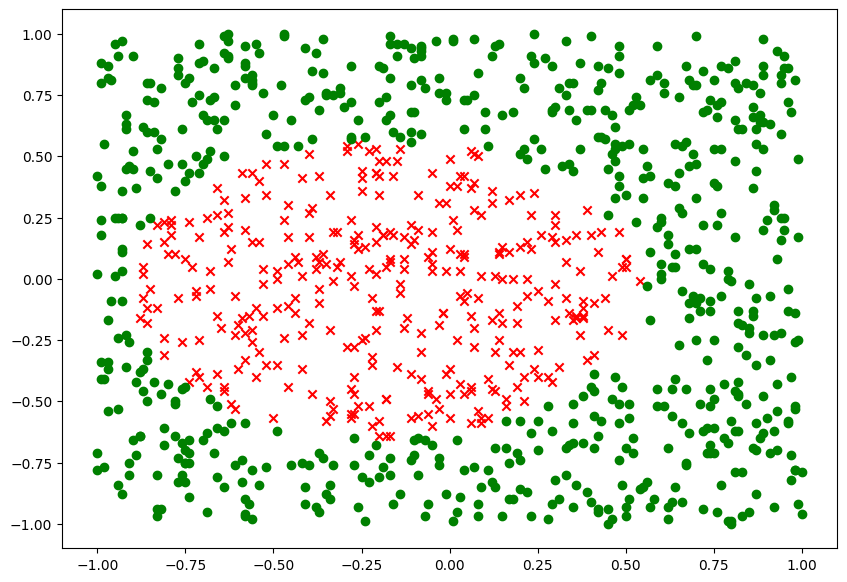

In [4]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "r", 1: "g"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# Show
plt.show()

### 2. Template for our Shallow Neural Network with Activation functions from Notebook 4

As in Notebook 4, below is the template class for a neural network consisting of a single linear layer, with sigmoid activation function. Let us try to train it and see its capabilities on the classification task.

In [5]:
class ShallowNeuralNet_WithAct_OneLayer():
    
    def __init__(self, n_x, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_y = n_y
        # Initialize parameters
        self.init_parameters_normal()
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
         
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W = np.random.randn(self.n_x, self.n_y)*0.1
        self.b = np.random.randn(1, self.n_y)*0.1

    def sigmoid(self, val):
        return 1/(1 + np.exp(-val))
    
    def forward(self, inputs):
        # Wx + b operation for the second layer
        Z = np.matmul(inputs, self.W)
        Z_b = Z + self.b
        y_pred = self.sigmoid(Z_b)
        return y_pred
    
    def CE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        eps = 1e-10
        losses = outputs*np.log(pred + eps) + (1 - outputs)*np.log(1 - pred + eps)
        self.loss = -np.sum(losses)/outputs.shape[0]
        return self.loss
    
    def backward(self, inputs, outputs, alpha = 1e-5):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z = np.matmul(inputs, self.W)
        Z_b = Z + self.b
        A = self.sigmoid(Z_b)
    
        # Compute error term
        dL_dA = -outputs/A + (1 - outputs)/(1 - A)
        dL_dZ = dL_dA*A*(1 - A)
        
        # Gradient descent update rules
        self.W -= (1/m)*alpha*np.dot(A.T, dL_dZ)
        self.b -= (1/m)*alpha*np.sum(dL_dZ, axis = 0, keepdims = True)
        
        # Update loss
        self.CE_loss(inputs, outputs)
    
    def train(self, inputs, outputs, N_max = 1000, alpha = 1e-5, delta = 1e-5, display = True):
        # List of losses, starts with the current loss
        self.losses_list = [self.loss]
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Backpropagate
            self.backward(inputs, outputs, alpha)
            new_loss = self.loss
            # Update losses list
            self.losses_list.append(new_loss)
            # Display
            if(display and iteration_number % (N_max*0.05) == 1):
                print("Iteration {} - Loss = {}".format(iteration_number, new_loss))
            # Check for delta value and early stop criterion
            difference = abs(self.losses_list[-1] - self.losses_list[-2])
            if(difference < delta):
                if(display):
                    print("Stopping early - loss evolution was less than delta on iteration {}.".format(iteration_number))
                break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
    
    def show_losses_over_training(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        # Display
        plt.show()

In [6]:
# Define and train neural network structure (with activation)
n_x = 2
n_y = 1
np.random.seed(37)
shallow_neural_net_act = ShallowNeuralNet_WithAct_OneLayer(n_x, n_y)
# Train and show final loss
shallow_neural_net_act.train(inputs, outputs, N_max = 10000, alpha = 1, delta = 1e-8, display = True)
print(shallow_neural_net_act.loss)

Iteration 1 - Loss = 0.6628996857776656
Stopping early - loss evolution was less than delta on iteration 467.
0.6239145092293222


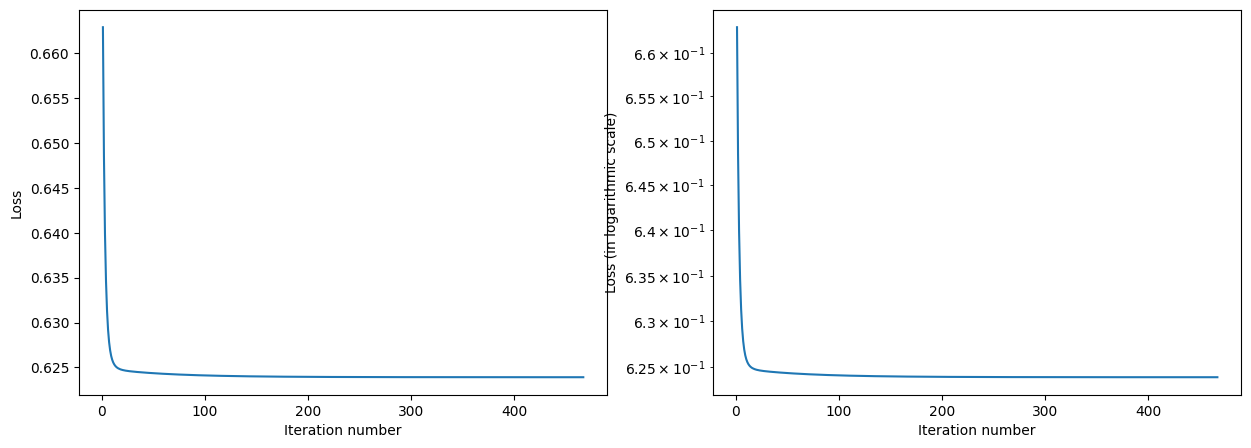

In [7]:
shallow_neural_net_act.show_losses_over_training()

The model trained, but we are not surprised to see that it struggles to classify... The model is too simple for the task.

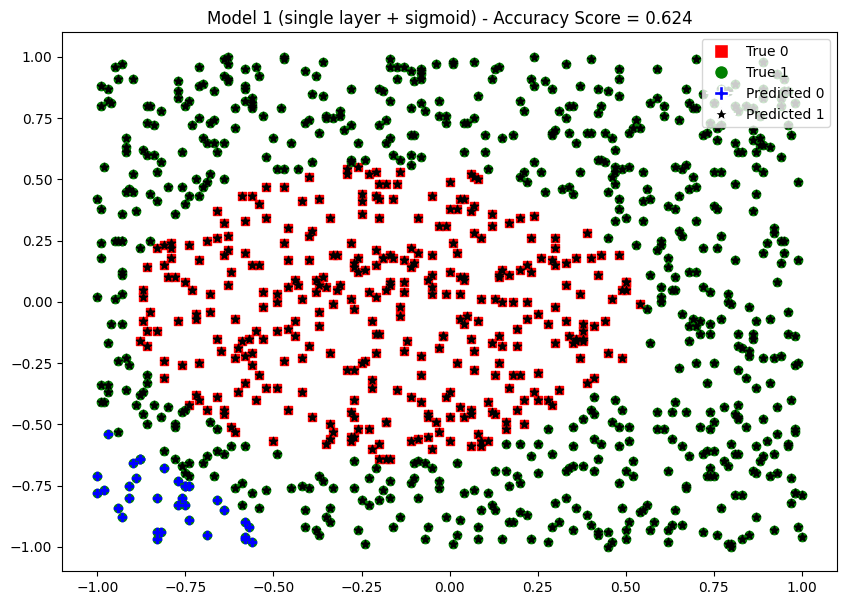

In [8]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# --- Scatter dataset plot
markers = {0: "s", 1: "o"}
colors = {0: "r", 1: "g"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# --- Make predictions 
outputs_pred = np.round(shallow_neural_net_act.forward(inputs))

# --- Scatter prediction plot
markers_pred = {0: "P", 1: "*"}
colors_pred = {0: "b", 1: "k"}
indexes_0_pred = np.where(outputs_pred == 0)[0]
v1_0_pred = val1_list[indexes_0_pred]
v2_0_pred = val2_list[indexes_0_pred]
indexes_1_pred = np.where(outputs_pred == 1)[0]
v1_1_pred = val1_list[indexes_1_pred]
v2_1_pred = val2_list[indexes_1_pred]
plt.scatter(v1_0_pred, v2_0_pred, c = colors_pred[0], marker = markers_pred[0])
plt.scatter(v1_1_pred, v2_1_pred, c = colors_pred[1], marker = markers_pred[1])

# --- Show legend
legend_elements = [Line2D([0], [0], marker = 's', color = 'w', label = 'True 0', \
                          markerfacecolor = 'r', markersize = 10),
                   Line2D([0], [0], marker = 'o', color = 'w', label = 'True 1', \
                          markerfacecolor = 'g', markersize = 10),
                   Line2D([0], [0], marker = 'P', color = 'w', label = 'Predicted 0', \
                          markerfacecolor = 'b', markersize = 10),
                   Line2D([0], [0], marker = '*', color = 'w', label = 'Predicted 1', \
                          markerfacecolor = 'k', markersize = 10)]
plt.legend(handles = legend_elements, loc = 'upper right')
acc = accuracy_score(outputs_pred, outputs)
plt.title("Model 1 (single layer + sigmoid) - Accuracy Score = {}".format(acc))
plt.show()

### 3. How about two layers then?

How about two layers then? (As in Notebook 4 also).

In [9]:
class ShallowNeuralNet_WithAct_TwoLayers():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Initialize parameters
        self.init_parameters_normal()
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
         
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(self.n_x, self.n_h)*0.1
        self.b1 = np.random.randn(1, self.n_h)*0.1
        self.W2 = np.random.randn(self.n_h, self.n_y)*0.1
        self.b2 = np.random.randn(1, self.n_y)*0.1

    def sigmoid(self, val):
        return 1/(1 + np.exp(-val))
    
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        # Wx + b operation for the second layer
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
        return y_pred
    
    def CE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        eps = 1e-10
        losses = outputs*np.log(pred + eps) + (1 - outputs)*np.log(1 - pred + eps)
        self.loss = -np.sum(losses)/outputs.shape[0]
        return self.loss
    
    def backward(self, inputs, outputs, alpha = 1e-5):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        A2 = self.sigmoid(Z2_b)
    
        # Compute error term
        dL_dA2 = -outputs/A2 + (1 - outputs)/(1 - A2)
        dL_dZ2 = dL_dA2*A2*(1 - A2)
        dL_dA1 = np.dot(dL_dZ2, self.W2.T)
        dL_dZ1 = dL_dA1*A1*(1 - A1)
        
        # Gradient descent update rules
        self.W2 -= (1/m)*alpha*np.dot(A1.T, dL_dZ2)
        self.W1 -= (1/m)*alpha*np.dot(inputs.T, dL_dZ1)
        self.b2 -= (1/m)*alpha*np.sum(dL_dZ2, axis = 0, keepdims = True)
        self.b1 -= (1/m)*alpha*np.sum(dL_dZ1, axis = 0, keepdims = True)
        
        # Update loss
        self.CE_loss(inputs, outputs)
    
    def train(self, inputs, outputs, N_max = 1000, alpha = 1e-5, delta = 1e-5, display = True):
        # List of losses, starts with the current loss
        self.losses_list = [self.loss]
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Backpropagate
            self.backward(inputs, outputs, alpha)
            new_loss = self.loss
            # Update losses list
            self.losses_list.append(new_loss)
            # Display
            if(display and iteration_number % (N_max*0.05) == 1):
                print("Iteration {} - Loss = {}".format(iteration_number, new_loss))
            # Check for delta value and early stop criterion
            difference = abs(self.losses_list[-1] - self.losses_list[-2])
            if(difference < delta):
                if(display):
                    print("Stopping early - loss evolution was less than delta on iteration {}.".format(iteration_number))
                break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
    
    def show_losses_over_training(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        # Display
        plt.show()

In [10]:
# Define and train neural network structure (with activation)
n_x = 2
n_h = 2
n_y = 1
np.random.seed(37)
shallow_neural_net_act2 = ShallowNeuralNet_WithAct_TwoLayers(n_x, n_h, n_y)
# Train and show final loss
shallow_neural_net_act2.train(inputs, outputs, N_max = 10000, alpha = 1, delta = 1e-8, display = True)
print(shallow_neural_net_act2.loss)

Iteration 1 - Loss = 0.6572939415037442
Iteration 501 - Loss = 0.5653094728989203
Iteration 1001 - Loss = 0.5338803386151092
Iteration 1501 - Loss = 0.5000578107101548
Iteration 2001 - Loss = 0.4741826492767281
Iteration 2501 - Loss = 0.4092220763318392
Iteration 3001 - Loss = 0.38354250939286955
Iteration 3501 - Loss = 0.3745724947773156
Iteration 4001 - Loss = 0.3705137264302391
Iteration 4501 - Loss = 0.36795020904484615
Iteration 5001 - Loss = 0.36515596436940345
Iteration 5501 - Loss = 0.36034231325482635
Iteration 6001 - Loss = 0.35584745560901887
Iteration 6501 - Loss = 0.3545210739894168
Iteration 7001 - Loss = 0.35422093686039446
Iteration 7501 - Loss = 0.3540275689668518
Iteration 8001 - Loss = 0.3538451069208992
Iteration 8501 - Loss = 0.35366770925378876
Iteration 9001 - Loss = 0.353493964657627
Iteration 9501 - Loss = 0.35332299483420865
Stopping - Maximal number of iterations reached.
0.3531545860761092


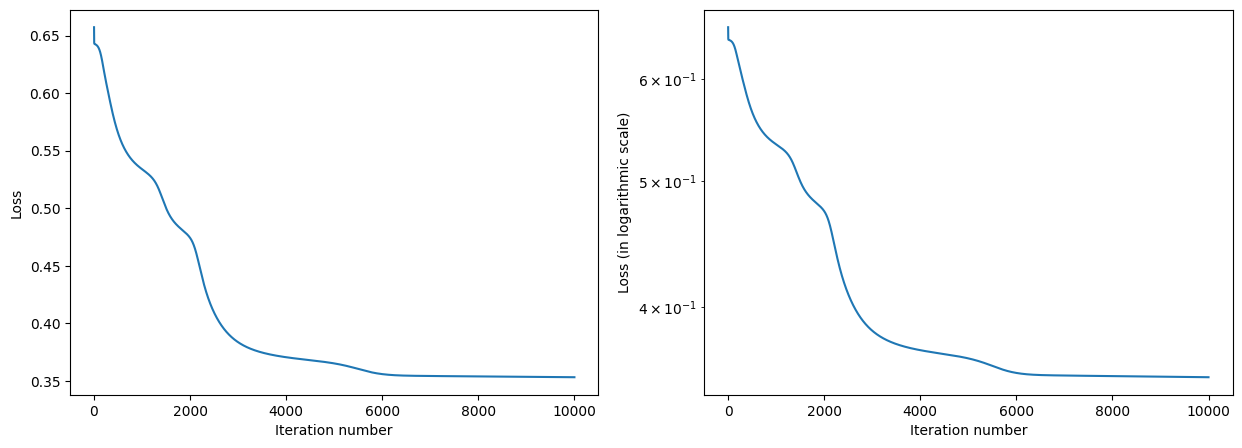

In [11]:
shallow_neural_net_act2.show_losses_over_training()

The model trained, is performing slightly better but it stil struggles to classify... Is the model still too simple for the task?

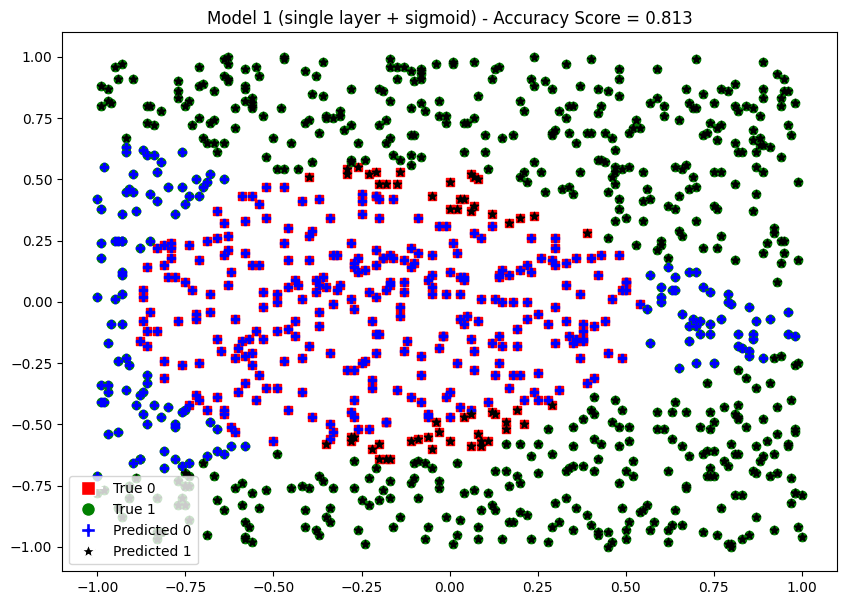

In [12]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# --- Scatter dataset plot
markers = {0: "s", 1: "o"}
colors = {0: "r", 1: "g"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# --- Make predictions 
outputs_pred = np.round(shallow_neural_net_act2.forward(inputs))

# --- Scatter prediction plot
markers_pred = {0: "P", 1: "*"}
colors_pred = {0: "b", 1: "k"}
indexes_0_pred = np.where(outputs_pred == 0)[0]
v1_0_pred = val1_list[indexes_0_pred]
v2_0_pred = val2_list[indexes_0_pred]
indexes_1_pred = np.where(outputs_pred == 1)[0]
v1_1_pred = val1_list[indexes_1_pred]
v2_1_pred = val2_list[indexes_1_pred]
plt.scatter(v1_0_pred, v2_0_pred, c = colors_pred[0], marker = markers_pred[0])
plt.scatter(v1_1_pred, v2_1_pred, c = colors_pred[1], marker = markers_pred[1])

# --- Show legend
legend_elements = [Line2D([0], [0], marker = 's', color = 'w', label = 'True 0', \
                          markerfacecolor = 'r', markersize = 10),
                   Line2D([0], [0], marker = 'o', color = 'w', label = 'True 1', \
                          markerfacecolor = 'g', markersize = 10),
                   Line2D([0], [0], marker = 'P', color = 'w', label = 'Predicted 0', \
                          markerfacecolor = 'b', markersize = 10),
                   Line2D([0], [0], marker = '*', color = 'w', label = 'Predicted 1', \
                          markerfacecolor = 'k', markersize = 10)]
plt.legend(handles = legend_elements, loc = 'best')
acc = accuracy_score(outputs_pred, outputs)
plt.title("Model 2 (two layers + sigmoid) - Accuracy Score = {}".format(acc))
plt.show()

### 4. How about adding more layers?

What if we decided to stick to the original inputs (no feature processing), but added more layers, e.g. a third one?

### Practice #1: How would you modify the template below to have a third layer with the following successive sizes?

$ N_x \rightarrow N_h \rightarrow N_{h2} \rightarrow N_y $

We already provide a suggestion for the init method, and parts where the code should probably be amended (we will probably need to amend some methods such as parameters initialization, forward and backward).

In [13]:
class ShallowNeuralNet_WithAct_ThreeLayers():
    
    def __init__(self, n_x, n_h, n_h2, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_h2 = n_h2
        self.n_y = n_y
        # Initialize parameters
        self.init_parameters_normal()
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
         
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(self.n_x, self.n_h)*0.1
        self.b1 = np.random.randn(1, self.n_h)*0.1
        self.W2 = np.random.randn(self.n_h, self.n_y)*0.1
        self.b2 = np.random.randn(1, self.n_y)*0.1
        """
        If a third layer is added, it will need parameters.
        """

    def sigmoid(self, val):
        return 1/(1 + np.exp(-val))
    
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        # Wx + b operation for the second layer
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
        """
        If a third layer is added, more operations will occur.
        """
        return y_pred
    
    def CE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        eps = 1e-10
        losses = outputs*np.log(pred + eps) + (1 - outputs)*np.log(1 - pred + eps)
        self.loss = -np.sum(losses)/outputs.shape[0]
        return self.loss
    
    def backward(self, inputs, outputs, alpha = 1e-5):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        A2 = self.sigmoid(Z2_b)
        """
        If a third layer is added, more operations will occur.
        """
    
        # Compute error term
        dL_dA2 = -outputs/A2 + (1 - outputs)/(1 - A2)
        dL_dZ2 = dL_dA2*A2*(1 - A2)
        dL_dA1 = np.dot(dL_dZ2, self.W2.T)
        dL_dZ1 = dL_dA1*A1*(1 - A1)
        """
        If a third layer is added, more gradients will have to be computed using the chain rule.
        """
        
        # Gradient descent update rules
        self.W2 -= (1/m)*alpha*np.dot(A1.T, dL_dZ2)
        self.W1 -= (1/m)*alpha*np.dot(inputs.T, dL_dZ1)
        self.b2 -= (1/m)*alpha*np.sum(dL_dZ2, axis = 0, keepdims = True)
        self.b1 -= (1/m)*alpha*np.sum(dL_dZ1, axis = 0, keepdims = True)
        """
        If a third layer is added, more gradient descent update rules will occur.
        """
        
        # Update loss
        self.CE_loss(inputs, outputs)
    
    def train(self, inputs, outputs, N_max = 1000, alpha = 1e-5, delta = 1e-5, display = True):
        # List of losses, starts with the current loss
        self.losses_list = [self.loss]
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Backpropagate
            self.backward(inputs, outputs, alpha)
            new_loss = self.loss
            # Update losses list
            self.losses_list.append(new_loss)
            # Display
            if(display and iteration_number % (N_max*0.05) == 1):
                print("Iteration {} - Loss = {}".format(iteration_number, new_loss))
            # Check for delta value and early stop criterion
            difference = abs(self.losses_list[-1] - self.losses_list[-2])
            if(difference < delta):
                if(display):
                    print("Stopping early - loss evolution was less than delta on iteration {}.".format(iteration_number))
                break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
    
    def show_losses_over_training(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        # Display
        plt.show()

In [17]:
# Define and train neural network structure (with activation)
n_x = 2
n_h = 2
n_h2 = 2
n_y = 1
np.random.seed(37)
shallow_neural_net_act3 = ShallowNeuralNet_WithAct_ThreeLayers(n_x, n_h, n_h2, n_y)
# Train and show final loss
shallow_neural_net_act3.train(inputs, outputs, N_max = 10000, alpha = 1, delta = 1e-12, display = True) #1e-12 on delta?
print(shallow_neural_net_act3.loss)

Iteration 1 - Loss = 0.6611843619878173
Iteration 501 - Loss = 0.6429993073404997
Iteration 1001 - Loss = 0.6429791168435625
Iteration 1501 - Loss = 0.6428695680966087
Iteration 2001 - Loss = 0.6415856740890737
Iteration 2501 - Loss = 0.5647744027578746
Iteration 3001 - Loss = 0.5205069344069837
Iteration 3501 - Loss = 0.38922062594732826
Iteration 4001 - Loss = 0.3558302906290232
Iteration 4501 - Loss = 0.3485839045305983
Iteration 5001 - Loss = 0.3373362026648829
Iteration 5501 - Loss = 0.31305597974658383
Iteration 6001 - Loss = 0.30743746016884566
Iteration 6501 - Loss = 0.3034387212569096
Iteration 7001 - Loss = 0.3000141373043388
Iteration 7501 - Loss = 0.29692832543658304
Iteration 8001 - Loss = 0.2941482420065298
Iteration 8501 - Loss = 0.2917218788214012
Iteration 9001 - Loss = 0.28966778597925164
Iteration 9501 - Loss = 0.28792202763669855
Stopping - Maximal number of iterations reached.
0.2863537305402338


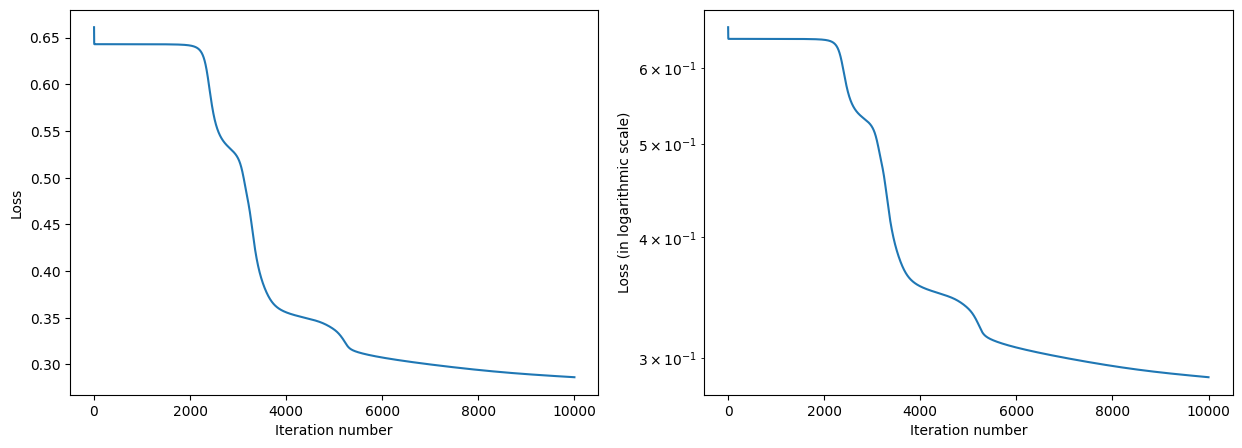

In [18]:
shallow_neural_net_act3.show_losses_over_training()

The model trained, but it still struggles to classify... It seems adding more layers will not do the trick here. It was still good practice nonetheless.

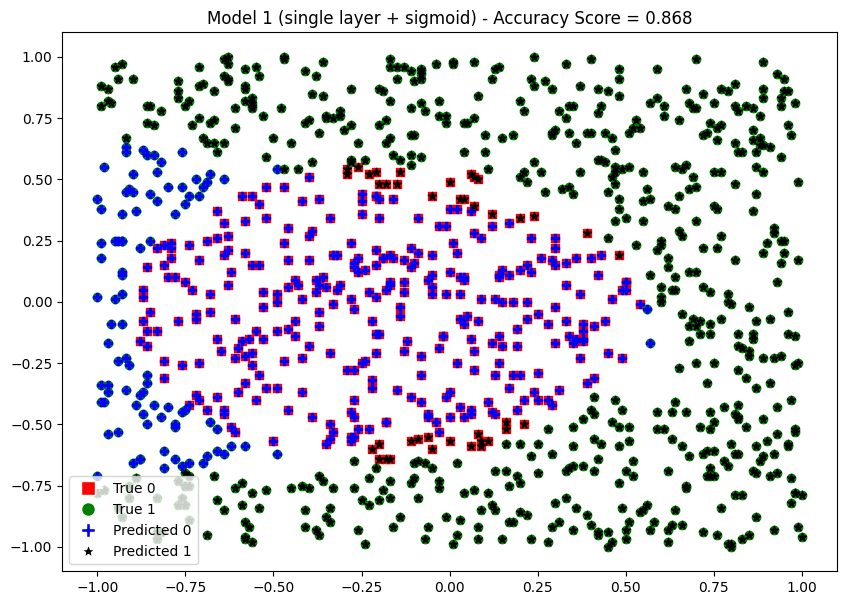

In [19]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# --- Scatter dataset plot
markers = {0: "s", 1: "o"}
colors = {0: "r", 1: "g"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# --- Make predictions 
outputs_pred = np.round(shallow_neural_net_act3.forward(inputs))

# --- Scatter prediction plot
markers_pred = {0: "P", 1: "*"}
colors_pred = {0: "b", 1: "k"}
indexes_0_pred = np.where(outputs_pred == 0)[0]
v1_0_pred = val1_list[indexes_0_pred]
v2_0_pred = val2_list[indexes_0_pred]
indexes_1_pred = np.where(outputs_pred == 1)[0]
v1_1_pred = val1_list[indexes_1_pred]
v2_1_pred = val2_list[indexes_1_pred]
plt.scatter(v1_0_pred, v2_0_pred, c = colors_pred[0], marker = markers_pred[0])
plt.scatter(v1_1_pred, v2_1_pred, c = colors_pred[1], marker = markers_pred[1])

# --- Show legend
legend_elements = [Line2D([0], [0], marker = 's', color = 'w', label = 'True 0', \
                          markerfacecolor = 'r', markersize = 10),
                   Line2D([0], [0], marker = 'o', color = 'w', label = 'True 1', \
                          markerfacecolor = 'g', markersize = 10),
                   Line2D([0], [0], marker = 'P', color = 'w', label = 'Predicted 0', \
                          markerfacecolor = 'b', markersize = 10),
                   Line2D([0], [0], marker = '*', color = 'w', label = 'Predicted 1', \
                          markerfacecolor = 'k', markersize = 10)]
plt.legend(handles = legend_elements, loc = 'best')
acc = accuracy_score(outputs_pred, outputs)
plt.title("Model 3 (three layers + sigmoid) - Accuracy Score = {}".format(acc))
plt.show()

### 5. How about some feature engineering instead?

### **Practice #2:** The mysterious equation seems to be using the squared values of the inputs. How about reworking the inputs so each sample consists of 4 values instead of 2, by adding the squared values of each original inputs?

In other words, let us process the inputs so that each input sample $ i $ in the dataset is transformed as:

$$ (val_1, val_2) \rightarrow (val_1, val_2, val_1^2, val_2^2) $$

Do note, that after this input transformation we will have to replace $ N_x = 2 $ with $ N_x = 4 $.

And let us go back to only using two layers instead of three as using more layers did not solve the problem.

In [ ]:
# Processing feature so they have squared values instead
def rework_inputs(inputs):
    """
    How would we rework the inputs so each sample has 4 features instead of 2?
    Basically, we want to add squared values along with the previous values.
    After the transformation inputs_processing will be an array with 4 columns instead of 2.
    """
    inputs_processing = None
    return inputs_processing

In [ ]:
# Processing feature so they have squared values instead
inputs_processing = rework_inputs(inputs)
print(inputs_processing)

In [ ]:
# Define and train neural network structure (with activation)
n_x = 4 # Instead of 2
n_h = 2
n_y = 1
np.random.seed(37)
shallow_neural_net_act4 = ShallowNeuralNet_WithAct_TwoLayers(n_x, n_h, n_y)
# Train and show final loss
shallow_neural_net_act4.train(inputs_processing, outputs, N_max = 10000, alpha = 1, delta = 1e-8, display = True)
print(shallow_neural_net_act4.loss)

In [ ]:
shallow_neural_net_act4.show_losses_over_training()

It should train, and classify correctly!

That is an important lesson for us: more often than not, adding more layers to the model will not solve the problem (it is a rookie mistake that will only cost youy more training time with very little gains). 

When possible, features engineering (that is, reworking your inputs to add relevant information that could help train a model) is best!

In [ ]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# --- Scatter dataset plot
markers = {0: "s", 1: "o"}
colors = {0: "r", 1: "g"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# --- Make predictions 
outputs_pred = np.round(shallow_neural_net_act4.forward(inputs_processing))

# --- Scatter prediction plot
markers_pred = {0: "P", 1: "*"}
colors_pred = {0: "b", 1: "k"}
indexes_0_pred = np.where(outputs_pred == 0)[0]
v1_0_pred = val1_list[indexes_0_pred]
v2_0_pred = val2_list[indexes_0_pred]
indexes_1_pred = np.where(outputs_pred == 1)[0]
v1_1_pred = val1_list[indexes_1_pred]
v2_1_pred = val2_list[indexes_1_pred]
plt.scatter(v1_0_pred, v2_0_pred, c = colors_pred[0], marker = markers_pred[0])
plt.scatter(v1_1_pred, v2_1_pred, c = colors_pred[1], marker = markers_pred[1])

# --- Show legend
legend_elements = [Line2D([0], [0], marker = 's', color = 'w', label = 'True 0', \
                          markerfacecolor = 'r', markersize = 10),
                   Line2D([0], [0], marker = 'o', color = 'w', label = 'True 1', \
                          markerfacecolor = 'g', markersize = 10),
                   Line2D([0], [0], marker = 'P', color = 'w', label = 'Predicted 0', \
                          markerfacecolor = 'b', markersize = 10),
                   Line2D([0], [0], marker = '*', color = 'w', label = 'Predicted 1', \
                          markerfacecolor = 'k', markersize = 10)]
plt.legend(handles = legend_elements, loc = 'best')
acc = accuracy_score(outputs_pred, outputs)
plt.title("Model 4 (two layers + sigmoid + feature engineering) - Accuracy Score = {}".format(acc))
plt.show()

### 6. How about two layers, but more neurons?

A thing that might help however, would be adding more neurons.

### **Practice #3:** Let us go back to our original two layers model, but this time, let us increase the size of the first layer, for instance, let us try using $ n_h = 10 $ instead of $ 2 $. Is that going to help?

In [ ]:
# Define and train neural network structure (with activation)
n_x = 2
"""
Should probably be modified?
"""
n_h = None
n_y = 1
np.random.seed(37)
shallow_neural_net_act5 = ShallowNeuralNet_WithAct_TwoLayers(n_x, n_h, n_y)
# Train and show final loss
shallow_neural_net_act5.train(inputs, outputs, N_max = 10000, alpha = 1, delta = 1e-8, display = True)
print(shallow_neural_net_act5.loss)

In [ ]:
shallow_neural_net_act5.show_losses_over_training()

It should train and classify almost perfectly!

That is another important lesson: having larger layers is often better than having more layers.

In [ ]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# --- Scatter dataset plot
markers = {0: "s", 1: "o"}
colors = {0: "r", 1: "g"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# --- Make predictions 
outputs_pred = np.round(shallow_neural_net_act5.forward(inputs))

# --- Scatter prediction plot
markers_pred = {0: "P", 1: "*"}
colors_pred = {0: "b", 1: "k"}
indexes_0_pred = np.where(outputs_pred == 0)[0]
v1_0_pred = val1_list[indexes_0_pred]
v2_0_pred = val2_list[indexes_0_pred]
indexes_1_pred = np.where(outputs_pred == 1)[0]
v1_1_pred = val1_list[indexes_1_pred]
v2_1_pred = val2_list[indexes_1_pred]
plt.scatter(v1_0_pred, v2_0_pred, c = colors_pred[0], marker = markers_pred[0])
plt.scatter(v1_1_pred, v2_1_pred, c = colors_pred[1], marker = markers_pred[1])

# --- Show legend
legend_elements = [Line2D([0], [0], marker = 's', color = 'w', label = 'True 0', \
                          markerfacecolor = 'r', markersize = 10),
                   Line2D([0], [0], marker = 'o', color = 'w', label = 'True 1', \
                          markerfacecolor = 'g', markersize = 10),
                   Line2D([0], [0], marker = 'P', color = 'w', label = 'Predicted 0', \
                          markerfacecolor = 'b', markersize = 10),
                   Line2D([0], [0], marker = '*', color = 'w', label = 'Predicted 1', \
                          markerfacecolor = 'k', markersize = 10)]
plt.legend(handles = legend_elements, loc = 'best')
acc = accuracy_score(outputs_pred, outputs)
plt.title("Model 5 (two layers + sigmoid + more neurons) - Accuracy Score = {}".format(acc))
plt.show()

### Typical homework questions would be

1. Show the ShallowNeuralNet_WithAct_ThreeLayers class you coded and explain the changes you made to the code.


2. Is the performance of the model improving when adding a third layer as suggested in Task 1?


3. Show the rework_inputs function you produced on task #2 and explain your logic in terms of code.


4. Is the performance of the model improving after feature engineering? If so, how could we explain this performance improvement?


5. Task #3 suggests using two layers model with more neurons is sufficient to address our underfitting issue. Could this be a good approach? How could we explain this intuitively?